# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the train and test datasets
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

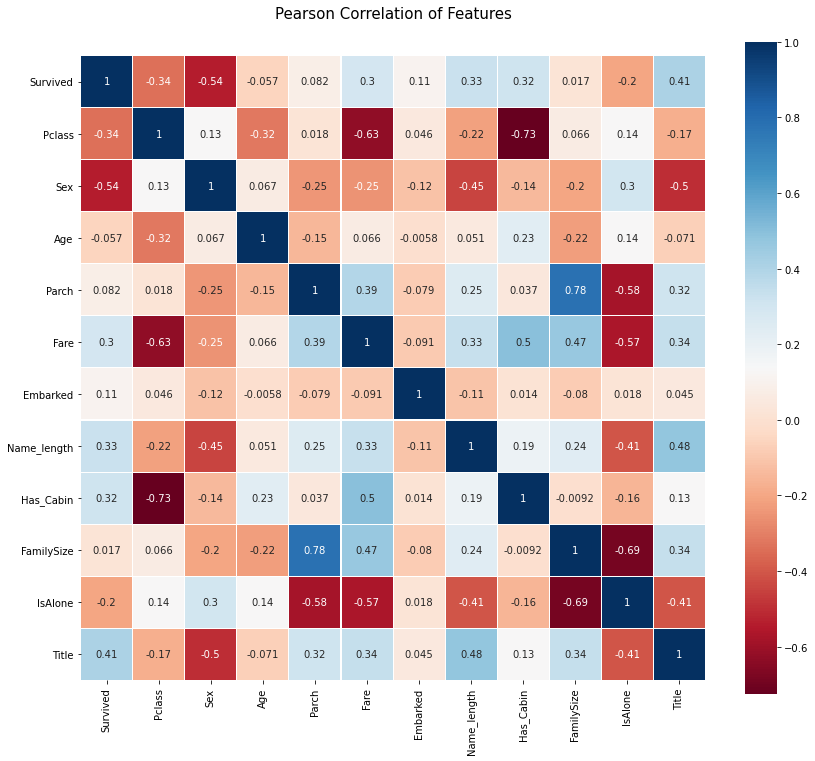

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

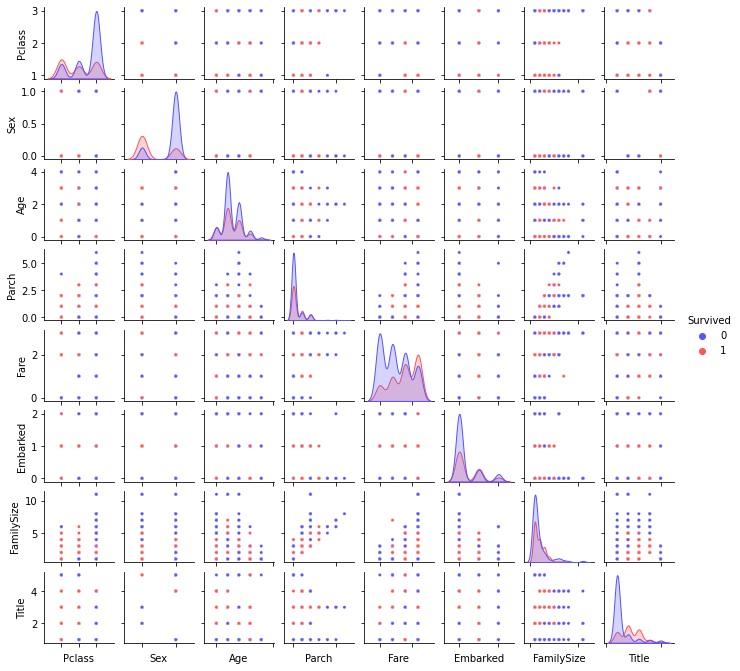

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

В качестве базовых алгоритмов используем RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделим данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмем столбец Survived, а в качестве признаков - все остальные столбцы).


In [8]:
def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, random_state=None, test_size=None, cv=5):
    
    """Реализация алгоритма Stacking
    
    models - список объектов базовых алгоритмов
    meta_alg - мета-алгоритм 
    data_train, targets_train, data_test, targets_test - тренировочные и тестовые признаки и целевые переменные
    test_size - размер тестовых данных для блендинга в промежутке (0, 1)
    cv - количество разбиений для кросс-валидации"""
    
    # stacking
    if test_size is None:
        # создание пустой матрицы meta_mtrx
        meta_mtrx = np.empty((data_train.shape[0], len(models)))
        # заполнение матрицы meta_mtrx
        for n, model in enumerate(models):
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv=cv, method='predict')
            model_obj = model.fit(data_train, targets_train)
            
        # мета-алгоритм
        meta_model = meta_alg.fit(meta_mtrx, targets_train)
        
        # мета-признаки базовых алгоритмов для тестовых данных
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
        
        # предсказания мета-алгоритма
        meta_predict = meta_model.predict(meta_mtrx_test)
        
        # выводим метрику auc
        if targets_test is not None:
            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')
        
        # вывод полученных предсказаний
        print(f'\nPredicted values: \n{meta_predict}')
        
        return meta_predict
        
    
    # blending
    elif test_size > 0 and test_size < 1:
        # Разбиение на тренировочные данные и валидационные данные
        train, valid, train_test, valid_test = train_test_split(data_train,
                                                               targets_train,
                                                               test_size=test_size,
                                                               random_state=random_state)
        # определение матрицы meta_mtrx
        meta_mtrx = np.empty((valid.shape[0], len(models)))
        # заполнение матрицы meta_mtrx
        for n, model in enumerate(models):
            model_obj = model.fit(train, train_test)
            meta_mtrx[:, n] = model_obj.predict(valid)
        
        # мета-алгоритм
        meta_model = meta_alg.fit(meta_mtrx, valid_test)
        
        # мета-признаки базовых алгоритмов для тестовых данных
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
        
        # предсказания мета-алгоритма
        meta_predict = meta.predict(meta_mtrx_test)
        
        # выводим метрику auc
        if targets_test is not None:
            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')
        
        # вывод полученных предсказаний
        print(f'\nPredicted values: \n{meta_predict}')
        
        return meta_predict
        
    else:
        raise ValueError("test_size must be between 0 and 1")

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [9]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold,
                                    cross_val_predict)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17)

In [10]:
targets = train.Survived
data = train.drop(columns='Survived')


# делаем разбивку
x_train, x_test, y_train, y_test = train_test_split(data, 
                                                    targets,
                                                    test_size=0.3,
                                                    random_state=17)

# определяем базовые алгоритмы
rfc = RandomForestClassifier(random_state=17)
svc = SVC(random_state=17)
gbc = GradientBoostingClassifier(random_state=17)
lr = LogisticRegression(random_state=17)

# определяем мета-алгоритм
meta = XGBClassifier(random_state=17, eval_metric='logloss')

# определяем список базовых алгоритмов
models = [rfc, lr, svc, gbc]

In [11]:
# определение объектов GridSearch для каждого базового алгоритма
grid_rfc = GridSearchCV(rfc, rfc_params, cv=skf)
grid_svc = GridSearchCV(svc, svc_params, cv=skf)
grid_gbc = GridSearchCV(gbc, gbc_params, cv=skf)
grid_lr = GridSearchCV(lr, lr_params, cv=skf)

**Обучение объектов GridSearch и вывод лучших параметров**

In [12]:
# алгоритм RandomForest
grid_rfc.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             estimator=RandomForestClassifier(random_state=17),
             param_grid={'min_samples_leaf': range(1, 5),
                         'n_estimators': range(10, 100, 10)})

In [13]:
rfc_best_params = grid_rfc.best_params_
rfc_best_params

{'min_samples_leaf': 3, 'n_estimators': 10}

In [14]:
# алгоритм Support Vector Classification
grid_svc.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             estimator=SVC(random_state=17),
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                         'kernel': ['linear', 'rbf']})

In [15]:
svc_best_params = grid_svc.best_params_
svc_best_params

{'C': 0.1, 'kernel': 'linear'}

In [16]:
# алгоритм GradientBoosting
grid_gbc.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=17),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5])})

In [17]:
gbc_best_params = grid_gbc.best_params_
gbc_best_params

{'learning_rate': 0.30000000000000004}

In [18]:
# алгоритм LogisticRegression
grid_lr.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             estimator=LogisticRegression(random_state=17),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9])})

In [19]:
lr_best_params = grid_lr.best_params_
lr_best_params

{'C': 0.5}

**Получение предсказаний для каждого объекта**

In [20]:
grid_rfc_predictions = grid_rfc.predict(x_test)
grid_svc_predictions = grid_svc.predict(x_test)
grid_gbc_predictions = grid_gbc.predict(x_test)
grid_lr_predictions = grid_lr.predict(x_test)

**Так как на Kaggle во вкладке 'Overwiew' в пункте 'Metric' указана 'accuracy', то ее и будем выводить**

In [21]:
from sklearn.metrics import accuracy_score

accuracy_rfc = accuracy_score(y_test, grid_rfc_predictions)
accuracy_svc = accuracy_score(y_test, grid_svc_predictions)
accuracy_gbc = accuracy_score(y_test, grid_gbc_predictions)
accuracy_lr = accuracy_score(y_test, grid_lr_predictions)

In [22]:
print(f'Accuracy of grid_rfc: {accuracy_rfc}, \n'
      f'Accuracy of grid_svc: {accuracy_svc}, \n'
      f'Accuracy of grid_gbc: {accuracy_gbc}, \n'
      f'Accuracy of grid_lr:  {accuracy_lr}, \n')

Accuracy of grid_rfc: 0.7798507462686567, 
Accuracy of grid_svc: 0.7873134328358209, 
Accuracy of grid_gbc: 0.7798507462686567, 
Accuracy of grid_lr:  0.7985074626865671, 



In [23]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [24]:
# настройки мета алгоритма
grid_meta = GridSearchCV(meta, xgb_params, cv=5)

# пустая матрица для метапризнаков
meta_mtrx = np.empty((x_test.shape[0], len(models)))

# список с предсказаниями базовых алгоритмов
base_predictions_list = [grid_rfc_predictions, grid_svc_predictions, grid_gbc_predictions, grid_lr_predictions]

# заполнение матрицы предсказаниями
for n, model in enumerate(base_predictions_list):
    meta_mtrx[:, n] = model

In [25]:
%%time
# обучение мета-алгоритма для получения лучших параметров

grid_meta.fit(meta_mtrx, y_test)

CPU times: user 46min 33s, sys: 28.3 s, total: 47min 1s
Wall time: 11min 57s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...s=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=17,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
   

In [26]:
# вывод лучших параметров
meta_best_params = grid_meta.best_params_
meta_best_params

{'eta': 0.6,
 'min_child_weight': 4,
 'n_estimators': 50,
 'subsample': 0.30000000000000004}

In [27]:
# определяем базовые алгоритмы с лучшими параметрами
rfc_best = RandomForestClassifier(min_samples_leaf=2, n_estimators=10)
svc_best = SVC(C=0.1, kernel='linear')
gbc_best = GradientBoostingClassifier(learning_rate=0.2)
lr_best = LogisticRegression(C=0.7999999999999999)

# определяем мета-алгоритм
meta_best = XGBClassifier(eta=meta_best_params['eta'],
                          min_child_weight=meta_best_params['min_child_weight'],
                          n_estimators=meta_best_params['n_estimators'],
                          subsample=meta_best_params['subsample'])

models = [rfc_best, svc_best, gbc_best, lr_best]

In [28]:
# выныносим столбец Survived в отдельную переменную и убираем из датасета 
targets = train.Survived
data = train.drop(columns='Survived')

In [29]:
# прогноз для мета-алгоритма
meta_predictions = stacking(models, meta_best, data, targets, test, targets_test=None, random_state=None, test_size=None, cv=5)

[10:50:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Predicted values: 
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 

In [30]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [31]:
write_to_submission_file(meta_predictions, PassengerId)